In [1]:
.L ../libAmBe.so

In [2]:
test // Test if lib loading is working

(const int) 11


In [3]:
char const* path {"../dataset/AmBe_x1-y1_Run_99.root"};
DataSetHolder dataset = ambeDataSet(path);

In [4]:
ROOT::RDF::RNode df = filterT1Events(dataset.df, 10e-6).Filter("is_event");

In [5]:
df.Count().GetValue()

(const unsigned long long) 86297


In [6]:
df = df.Define("chainMaskT9", "decayChainMask(T9.parentid, T9.trackid, T9.pdg, T9.CreatorProcessID, T9.initialEkin)");

In [7]:
df = createT5Mask(df);

In [8]:
df = df.Define("volidCE", "volidEpvtTot(volid[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD], edep_pvt[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD])");
df = df.Define("edep_pvtCE", "std::get<1>(volidCE)");
df = df.Redefine("volidCE", "std::get<0>(volidCE)");

In [9]:
df = df.Define("volidGamma", "volidEpvtTot(volid[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD], edep_pvt[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD])");
df = df.Define("edep_pvtGamma", "std::get<1>(volidGamma)");
df = df.Redefine("volidGamma", "std::get<0>(volidGamma)");

In [10]:
df = df.Define("firstGVolid", "T9.firstVolID[chainMaskT9 == maskGAMMA].size() ? T9.firstVolID[chainMaskT9 == maskGAMMA].at(0): -1");
df = df.Define("lastGVolid", "T9.lastVolID[chainMaskT9 == maskGAMMA].size() ? T9.lastVolID[chainMaskT9 == maskGAMMA].at(0): -1");
df = df.Define("maxEpvtGVolid", [](ROOT::RVec<double>& Epvt , ROOT::RVec<int>& volid){int index = indexMax(Epvt); return ((index > -1) ? volid[index] : -1);}, {"edep_pvtGamma", "volidGamma"});

In [11]:
df = df.Define("firstCEVolid", "T9.firstVolID[chainMaskT9 == maskCE_ELECT].size() ? T9.firstVolID[chainMaskT9 == maskCE_ELECT].at(0): -1");
df = df.Define("lastCEVolid", "T9.lastVolID[chainMaskT9 == maskCE_ELECT].size() ? T9.lastVolID[chainMaskT9 == maskCE_ELECT].at(0): -1");
df = df.Define("maxEpvtCEVolid", [](ROOT::RVec<double>& Epvt , ROOT::RVec<int>& volid){int index = indexMax(Epvt); return ((index > -1) ? volid[index] : -1);}, {"edep_pvtCE", "volidCE"});

In [12]:
df = df.Filter("ROOT::VecOps::Any(chainMaskT5 == maskGAMMA)").Filter("ROOT::VecOps::Any(chainMaskT5 == maskCE_ELECT)").Filter("ROOT::VecOps::Any(T9.initialEkin[chainMaskT9 == maskCE_ELECT] > 4)");

In [13]:
df.Count().GetValue()

(const unsigned long long) 4595


In [14]:
df  = df.Filter("ROOT::VecOps::Sum(edep_pvtGamma > 0.05) == 1").Filter("ROOT::VecOps::Sum(edep_pvtCE > 0.05) == 1");

In [15]:
df.Count().GetValue()

(const unsigned long long) 1199


In [16]:
df = df.Define("CEHammingDist", "hammingDist(maxEpvtCEVolid, volidCE)");

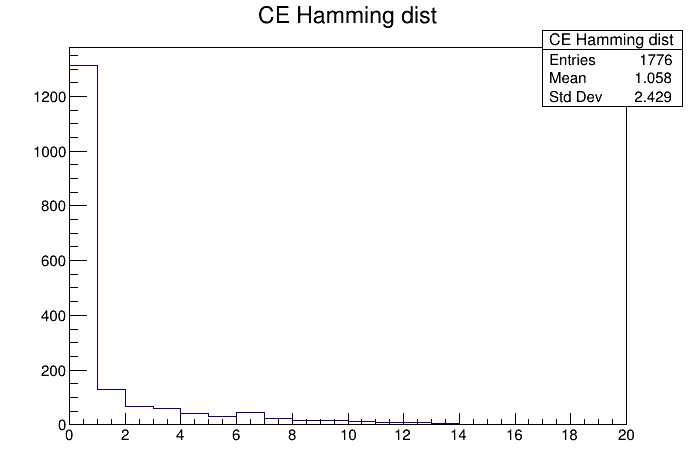

Info in <TCanvas::Print>: pdf file ../plots/pdf/CEHammingDist.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/CEHammingDist.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/CEHammingDist.png has been created


In [17]:
TCanvas c;
auto hist = df.Histo1D({"CE Hamming dist", "CE Hamming dist", 20u, 0., 20.0}, "CEHammingDist")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"CEHammingDist"};
savePlot(hist, dir, file);

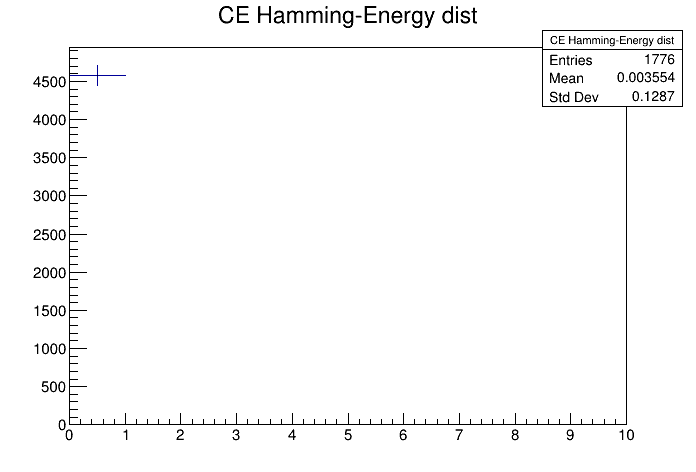

Info in <TCanvas::Print>: pdf file ../plots/pdf/CEHammingEnergyDist.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/CEHammingEnergyDist.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/CEHammingEnergyDist.png has been created


In [18]:
TCanvas c;
auto hist = df.Histo1D<ROOT::RVec<int>, ROOT::RVec<double>>( {"CE Hamming-Energy dist", "CE Hamming-Energy dist", 10u, 0., 10.0}, "CEHammingDist", "edep_pvtCE")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"CEHammingEnergyDist"};
savePlot(hist, dir, file);

In [19]:
df = df.Define("GHammingDist", "hammingDist(lastGVolid, volidGamma[edep_pvtGamma > 0.05])");

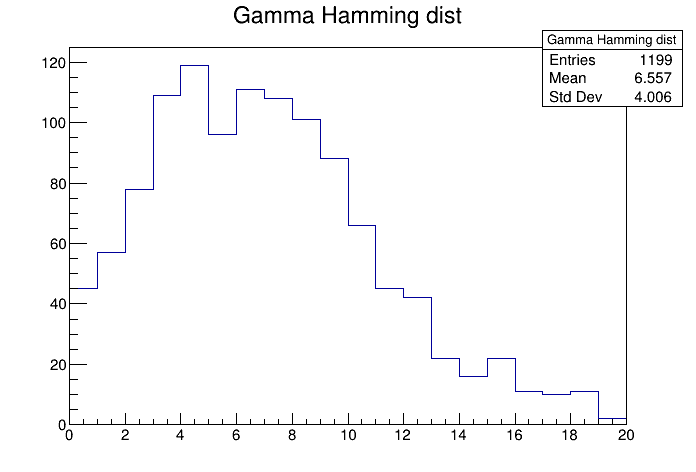

Info in <TCanvas::Print>: pdf file ../plots/pdf/GammaHammingDist.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/GammaHammingDist.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/GammaHammingDist.png has been created


In [20]:
TCanvas c;
auto hist = df.Histo1D({"Gamma Hamming dist", "Gamma Hamming dist", 20u, 0., 20.0}, "GHammingDist")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaHammingDist"};
savePlot(hist, dir, file);

In [21]:
TCanvas c;
auto hist = df.Histo1D<ROOT::RVec<int>, ROOT::RVec<double>>({"Gamma Hamming-Ennergy dist", "Gamma Hamming-Ennergy dist", 20u, 0., 20.0}, "GHammingDist", "edep_pvtGamma[edep_pvtGamma > 0.05]")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaHammingEnnergyDist"};
savePlot(hist, dir, file);

In [22]:
df = df.Define("GammaCoM", "centerOfMass(volidGamma, edep_pvtGamma[edep_pvtGamma > 0.05])");

In [23]:
df = df.Define("GCoMHammingDist", "neightborDist(GammaCoM, volidGamma[edep_pvtGamma > 0.05])");

In [24]:
TCanvas c;
auto hist = df.Histo1D({"GammaCoM Hamming dist", "GammaCoM Hamming dist", 40u, -20., 20.0}, "GCoMHammingDist")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaCoMHammingDist"};
savePlot(hist, dir, file);

RDataFrame::Run: event loop was interrupted


In [25]:
TCanvas c;
auto hist = df.Histo1D<ROOT::RVec<int>, ROOT::RVec<double>>({"Gamma CoM Hamming-Ennergy dist", "Gamma CoM Hamming-Ennergy dist", 40u, -19., 21.0}, "GCoMHammingDist", "edep_pvtGamma[edep_pvtGamma > 0.05]")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaCoMHammingEnnergyDist"};
savePlot(hist, dir, file);

In [26]:
df = df.Define("distGrefCeref", "euclidDist(GammaCoM, {maxEpvtCEVolid})");

In [27]:
TCanvas c;
auto hist = df.Histo1D({"Gamma-CE Hamming dist", "Gamma-CE Hamming dist", 20u, 0., 20.0}, "distGrefCeref")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaCEHammingDist"};
savePlot(hist, dir, file);

RDataFrame::Run: event loop was interrupted


std::ofstream outputfileT5 ("T5.txt", std::ofstream::out);
outputfileT5 << df.Display({
    "chainMaskT5", "pdg", "trackid", "parentid", "volid", "edep_pvt"
}, 100, 1000)->AsString();
outputfileT5.close()

std::ofstream outputfileT9 ("T9.txt", std::ofstream::out);
outputfileT9 << df.Display({
    "chainMaskT9", "T9.pdg", "T9.trackid", "T9.parentid", "T9.firstVolID", "T9.lastVolID", "T9.initialEkin"
}, 100, 1000)->AsString();
outputfileT9.close()

std::ofstream outputfileDef ("Def.txt", std::ofstream::out);
outputfileDef << df.Display({
    "firstCEVolid", "maxEpvtCEVolid", "lastCEVolid", "edep_pvtCE", "volidCE", "CEHammingDist",
    "firstGVolid", "maxEpvtGVolid", "lastGVolid", "edep_pvtGamma", "volidGamma", "GHammingDist"
}, 100, 1000)->AsString();
outputfileDef.close()

In [28]:
df.Count().GetValue()

(const unsigned long long) 1199


In [29]:
df.Filter("(distGrefCeref >= 4).at(0)").Count().GetValue()

RDataFrame::Run: event loop was interrupted
